# Exploring the Idea of a Correlation Matrix Heatmap

This notebook explores the idea of a "correlation matrix heatmap" that is frequently used to show the strength of relationships between quantititave variables. A similar idea for categorical data would show the *strength of the association* between categorical variables.

This blog post has an idea for creating an equivalent to a correlation matrix heatmap for categorical variables:  
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

The package repository can be found here: https://github.com/shakedzy/dython 

This particular package may or may not be suitable for this project, but the statistical methods demonstrated here may be useful.



In [1]:
# Dython is a third-party data analytics package for python
!pip install dython

In [2]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd

from dython.nominal import associations

# Data
The data comes from 183 documents where the fields have been extracted manually.


In [3]:
keep_columns = ['Judge Name', 
                'Assigned Office', 
                'Court/Venue', 
                'Country Of Origin',
                'Potential Protected Grounds',
                'Particular Social Group(s)',
                'Outcome',
                ]

real_df = pd.read_csv(
    'KL_Lambda_Report_2.csv',
    skiprows=2, 
    usecols=keep_columns
    )

In [4]:
real_df.head()

,Assigned Office,Court/Venue,Judge Name,Outcome,Country Of Origin,Potential Protected Grounds,Particular Social Group(s)
0,Washington,Arlington Immigration Court,N/A N/A,Pending,Venezuela,Political Opinion,NaN
1,Washington,Arlington Immigration Court,Emmett D. Soper,Pending,El Salvador,NaN,NaN
2,Washington,Baltimore Immigration Court,N/A N/A,Pending,El Salvador,Social Group,"Family or Kinship Ties, Other"
3,Washington,Baltimore Immigration Court,N/A N/A,Pending,Guatemala,Social Group,Family or Kinship Ties
4,Washington,Baltimore Immigration Court,N/A N/A,Pending,El Salvador,Social Group,Domestic Violence


# Generating a heatmap using `dython`

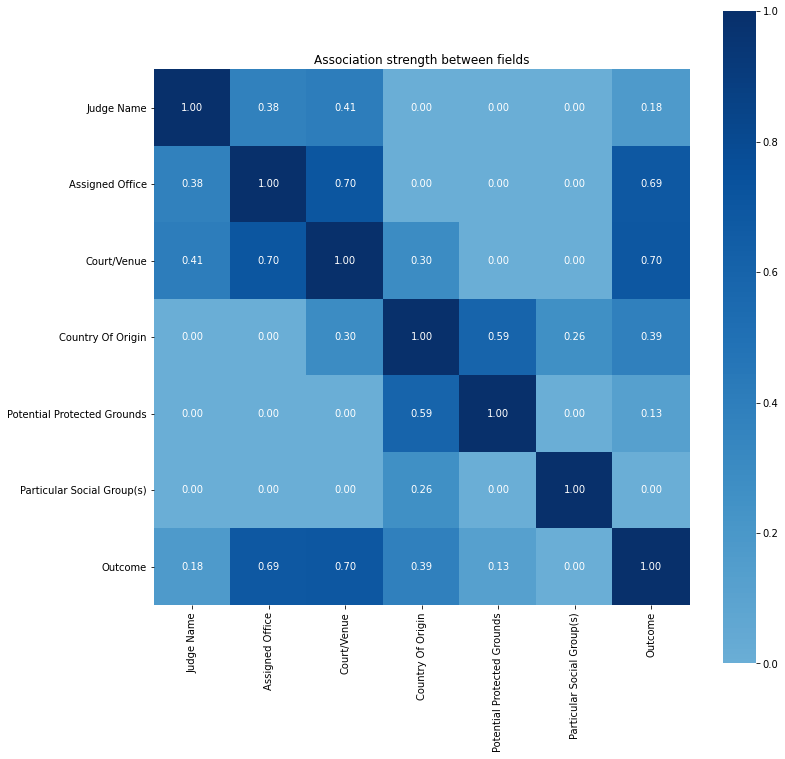

In [5]:
fig, ax = plt.subplots(figsize=(12,12))

association_dict = associations(
    real_df[keep_columns], 
    cmap='Blues', 
    ax=ax,      # sets the axis handle so fig can be finetuned with mpl 
    title='Association strength between fields'
    )
correlations = association_dict['corr'] # the matrix of cramer's v values
corr_ax = association_dict['ax']        # an AxesSubplot object 

# Cramer's V
This is the value used to show the strength of the association between two categorical variables. Essentially, we compute this value for all pairs of variables, place the result of this calculation in a dataframe, and use that dataframe to construct a heatmap.

This function can take pandas series for both `x` and `y`.  
When `theil_u=False` in the `associations` function, Cramer's V is used to calculate the corresponding value in the matrix seen above.

In [6]:
import numpy as np
import scipy.stats as ss

def cramers_v(x, y):
    
    confusion_matrix = pd.crosstab(x,y)
    # calculate the chi2 statistic
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2 / (n-1)
    kcorr = k - (k-1)**2 / (n-1)

    return np.sqrt(phi2corr/min(kcorr-1, rcorr-1))

In [7]:
cramers_v(real_df['Judge Name'], real_df['Outcome'])

0.11625876010929789

# Visualization validation
Here we create fake data to test that the visualization does what we expect it to.  
First we create fully randomized data.  
Then, we add some bias and check that the corresponding fields show a stronger association.


__WARNING: The data shown here might not reflect the actual data collected. It is purely for testing purposes.__

In [8]:
# possible categories
application_types = [
        'Waiver of removability', 
        'Convention Against Torture',
        'Asylum',
        ]
countries = [
        'Tunisia',
        'Ghana', 
        'Honduras', 
        'Mexico',
        'Zaire', 
        'Haiti', 
        'El Salvador', 
        'Bangladesh',
        ]
protected_grounds = [
        'social',
        'political',
        'race',
        'religion', 
        'None',
        ]
based_violence = [
        'family',
        'gang', 
        'gender',
        'None',
        ]
outcomes = [
        'Sustained',
        'Dismissed',
        'Remanded',
        'Granted',
        ]


In [9]:
category_list = [
        application_types, 
        countries, 
        protected_grounds, 
        based_violence, 
        outcomes,
        ]
columns = ['application_type', 'country', 'protected_ground', 'based_violence', 'outcome']
df = pd.DataFrame(columns=columns)

In [10]:
import random

for _ in range(1000):
    df = df.append(
        {col: random.choice(category) for col,category in zip(columns, category_list)}, 
        ignore_index=True
        )

df.head()

,application_type,country,protected_ground,based_violence,outcome
0,Asylum,Zaire,social,gender,Remanded
1,Waiver of removability,Ghana,race,family,Dismissed
2,Waiver of removability,El Salvador,religion,gang,Sustained
3,Convention Against Torture,El Salvador,None,gender,Sustained
4,Asylum,Bangladesh,political,None,Dismissed


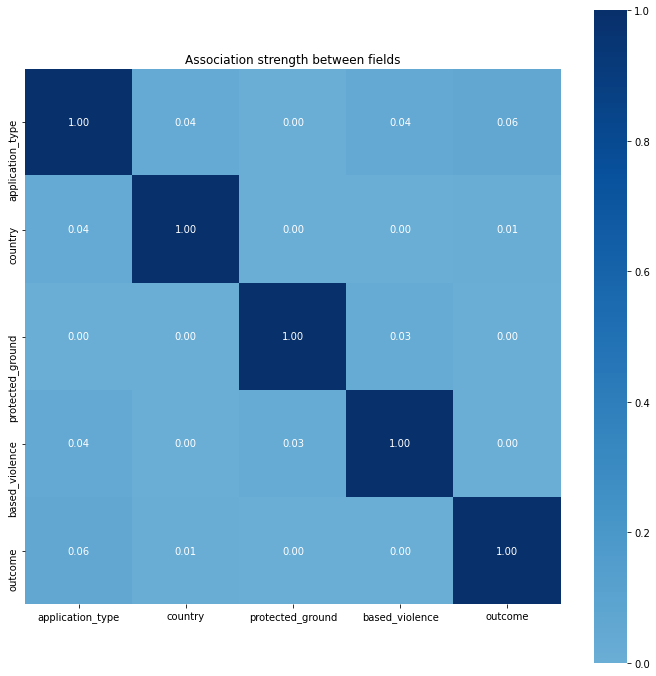

In [11]:
fig, ax = plt.subplots(figsize=(12,12))

associations(
    df, 
    theil_u=False, 
    cmap='Blues', 
    ax=ax,
    title='Association strength between fields'
    );

## Biasing the randomized data
We want to bias our dataset towards specific correlations in order to validate visualizations created using this fake dataset.

To do so, we will put our thumb on the scale and add a few more entries to the dataframe.

In [12]:
for _ in range(100):
    # generate data entry from uniform distribution for each column
    data = {col: random.choice(category) for col,category in zip(columns, category_list)}
    
    # Bias the random entry towards a specific pair of values
    data['application_type'] = 'Convention Against Torture'
    data['outcome'] = 'Granted'

    # add entry to dataframe
    df = df.append(data, ignore_index=True)

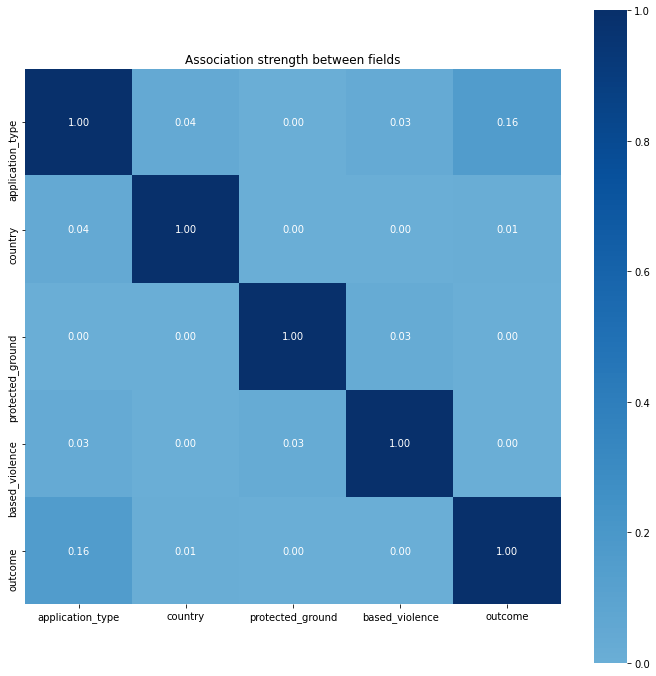

In [13]:
fig, ax = plt.subplots(figsize=(12,12))

associations(
    df, 
    theil_u=False, 
    cmap='Blues', 
    ax=ax,
    title='Association strength between fields'
    );